## Preparation

In [1]:
! pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 51.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 90.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 72.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 31.1 MB/s eta 0:00:00


In [2]:
import os
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from transformers import *
import pickle
import csv
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import ast
from sklearn.decomposition import PCA
import torch.utils.data as Data
from torch.utils.data import Dataset, DataLoader

/usr/local/lib/python3.10/dist-packages/transformers/deepspeed.py:23: FutureWarning: transformers.deepspeed module is deprecated and will be removed in a future version. Please import deepspeed modules directly from transformers.integrations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation_utils.py:24: FutureWarning: Importing `GenerationMixin` from `src/transformers/generation_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import GenerationMixin` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation_tf_utils.py:24: FutureWarning: Importing `TFGenerationMixin` from `src/transformers/generation_tf_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import TFGenerationMixin` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation_flax_utils.py:24: FutureWarning: Importing `FlaxGenerationMixin` from `sr

In [3]:
torch.manual_seed(37)
torch.cuda.manual_seed(37)
np.random.seed(37)

DATA_DIR = "/content/drive/MyDrive"

In [4]:
TOKEN_LEN = 50
VOCAB_SIZE = 100000
LaBSE_DIM = 768
EMBED_DIM = 300
BATCH_SIZE = 96
FASTTEXT_DIM = 300
NEIGHBOR_SIZE = 20
ATTENTION_DIM = 300
MULTI_HEAD_DIM = 1

LINK_LEN = 15000

## Load DBP15k and Convert KG into Unispace

In [5]:
class DBP15kRawLoader():
    def __init__(self, language="zh_en", dataset='1'):
        self.language = language
        self.dataset = dataset
        self.id_entity = {}
        self.load()

    def load(self):
        path = os.path.join(DATA_DIR, 'DBP15K', self.language)
        with open(os.path.join(path, f"cleaned_ent_ids_{self.dataset}"), encoding='utf-8') as f:
            lines = f.readlines()
            for line in lines:
                l = line.split('\t')
                id = int(l[0])
                entity = str(l[1])
                self.id_entity[id] = entity

In [6]:
MAX_LEN = 130

class LaBSEEncoder(nn.Module):
    def __init__(self):
        super(LaBSEEncoder, self).__init__()
        self.device = device
        self.tokenizer = AutoTokenizer.from_pretrained(os.path.join(DATA_DIR, "LaBSE"), do_lower_case=False)
        self.model = AutoModel.from_pretrained(os.path.join(DATA_DIR, "LaBSE")).to(self.device)

    def forward(self, batch):
        sentences = batch
        #  text input must of type `str` (single example), `List[str]` (batch or single pretokenized example) or `List[List[str]]` (batch of pretokenized examples).
        tok_res = self.tokenizer(sentences, add_special_tokens=True, padding='max_length', max_length=MAX_LEN)
        input_ids = torch.LongTensor([d[:MAX_LEN] for d in tok_res['input_ids']]).to(self.device)
        token_type_ids = torch.LongTensor(tok_res['token_type_ids']).to(self.device)
        attention_mask = torch.LongTensor(tok_res['attention_mask']).to(self.device)
        output = self.model(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)
        return F.normalize(output[0][:, 1:-1, :].sum(dim=1))

In [7]:
class Embedding(object):
    def __init__(self):

        self.loader1 = DBP15kRawLoader("zh_en", '1').id_entity
        self.loader2 = DBP15kRawLoader("zh_en", '2').id_entity

        self.model = LaBSEEncoder().to(device)

    def embedding(self):

        id_embedding_1 = {}
        for i, (_id, _ent_name) in tqdm(enumerate(self.loader1.items())):
            emb = self.model([_ent_name]).cpu().detach().numpy().tolist()
            id_embedding_1[int(_id)] = emb
        with open(os.path.join(dir_path, "raw_LaBSE_emb_1.pkl"),'wb') as f:
            pickle.dump(id_embedding_1, f)

        id_embedding_2 = {}
        for i, (_id, _ent_name) in tqdm(enumerate(self.loader2.items())):
            emb = self.model([_ent_name]).cpu().detach().numpy().tolist()
            id_embedding_2[int(_id)] = emb
        with open(os.path.join(dir_path, "raw_LaBSE_emb_2.pkl"),'wb') as f:
            pickle.dump(id_embedding_2, f)

In [8]:
'''
if __name__ == "__main__":
    device = "cuda:0"
    embeder = Embedding()
    language_list = ["zh_en"]
    for language in language_list:
        dir_path = os.path.join(DATA_DIR, 'DBP15K', language)
        embeder.embedding()
'''

'\nif __name__ == "__main__":\n    device = "cuda:0"\n    embeder = Embedding()\n    language_list = ["zh_en"]\n    for language in language_list:\n        dir_path = os.path.join(DATA_DIR, \'DBP15K\', language)\n        embeder.embedding()\n'

In [9]:
class DBP15KRawNeighbors():
    def __init__(self, language, doc_id):
        self.language = language
        self.doc_id = doc_id
        self.path = os.path.join(DATA_DIR, 'DBP15K', self.language)
        self.id_entity = {}
        # self.id_neighbor_loader = {}
        self.id_adj_tensor_dict = {}
        self.id_neighbors_dict = {}
        self.load()
        self.id_neighbors_loader()
        self.get_center_adj()

    def load(self):
        with open(os.path.join(self.path, "raw_LaBSE_emb_" + self.doc_id + '.pkl'), 'rb') as f:
            self.id_entity = pickle.load(f)


    def id_neighbors_loader(self):
        data = pd.read_csv(os.path.join(self.path, 'triples_' + self.doc_id), header=None, sep='\t')
        data.columns = ['head', 'relation', 'tail']
        # self.id_neighbor_loader = {head: {relation: [neighbor1, neighbor2, ...]}}

        for index, row in data.iterrows():
            # head-rel-tail, tail is a neighbor of head
            # print("int(row['head']): ", int(row['head']))
            head_str = self.id_entity[int(row['head'])][0]
            tail_str = self.id_entity[int(row['tail'])][0]

            if not int(row['head']) in self.id_neighbors_dict.keys():
                self.id_neighbors_dict[int(row['head'])] = [head_str]
            if not tail_str in self.id_neighbors_dict[int(row['head'])]:
                self.id_neighbors_dict[int(row['head'])].append(tail_str)

            if not int(row['tail']) in self.id_neighbors_dict.keys():
                self.id_neighbors_dict[int(row['tail'])] = [tail_str]
            if not head_str in self.id_neighbors_dict[int(row['tail'])]:
                self.id_neighbors_dict[int(row['tail'])].append(head_str)

    def get_adj(self, valid_len):
        adj = torch.zeros(NEIGHBOR_SIZE, NEIGHBOR_SIZE).bool()
        for i in range(0, valid_len):
            adj[i, i] = 1
            adj[0, i] = 1
            adj[i, 0] = 1
        return adj

    def get_center_adj(self):
        for k, v in self.id_neighbors_dict.items():
            if len(v) < NEIGHBOR_SIZE:
                self.id_adj_tensor_dict[k] = self.get_adj(len(v))
                self.id_neighbors_dict[k] = v + [[0]*LaBSE_DIM] * (NEIGHBOR_SIZE - len(v))
            else:
                self.id_adj_tensor_dict[k] = self.get_adj(NEIGHBOR_SIZE)
                self.id_neighbors_dict[k] = v[:NEIGHBOR_SIZE]

In [10]:
class MyRawdataset(Dataset):
    def __init__(self, id_features_dict, adj_tensor_dict,is_neighbor=True):
        super(MyRawdataset, self).__init__()
        self.num = len(id_features_dict)  # number of samples

        self.x_train = []
        self.x_train_adj = None
        self.y_train = []

        for k in id_features_dict:
            if is_neighbor:
                if self.x_train_adj==None:
                    self.x_train_adj = adj_tensor_dict[k].unsqueeze(0)
                else:
                    self.x_train_adj = torch.cat((self.x_train_adj, adj_tensor_dict[k].unsqueeze(0)), dim=0)
            self.x_train.append(id_features_dict[k])
            self.y_train.append([k])

        # transfer to tensor
        # if type(self.x_train[0]) is list:
        self.x_train = torch.Tensor(self.x_train)
        if is_neighbor:
            self.x_train = torch.cat((self.x_train, self.x_train_adj), dim=2)
        self.y_train = torch.Tensor(self.y_train).long()

    # indexing
    def __getitem__(self, index):
        return self.x_train[index], self.y_train[index]

    def __len__(self):
        return self.num

In [11]:
class Trainer(object):
    def __init__(self, training=True, seed=37):

        self.device = device

        loader1 = DBP15KRawNeighbors("zh_en", "1")
        myset1 = MyRawdataset(loader1.id_neighbors_dict, loader1.id_adj_tensor_dict)
        del loader1

        self.loader1 = Data.DataLoader(
            dataset=myset1,  # torch TensorDataset format
        )

        del myset1

        loader2 = DBP15KRawNeighbors("zh_en", "2")
        myset2 = MyRawdataset(loader2.id_neighbors_dict, loader2.id_adj_tensor_dict)
        del loader2

        self.loader2 = Data.DataLoader(
            dataset=myset2,  # torch TensorDataset format
        )

        del myset2

        # Initialize lists to store x and y values
        x_data = []
        y_data = []

        # Collect data from loader1
        for batch_idx, (x_train, y_train) in enumerate(self.loader1):
            x_data.extend(x_train.tolist())
            y_data.extend(y_train.tolist())

        # Create a DataFrame for loader1 data
        self.loader1_dataframe = pd.DataFrame({
            'x_values': x_data,
            'y_values': y_data
        })

        # Reset lists for loader2 data
        x_data = []
        y_data = []

        # Collect data from loader2
        for batch_idx, (x_train, y_train) in enumerate(self.loader2):
            x_data.extend(x_train.tolist())
            y_data.extend(y_train.tolist())

        # Create a DataFrame for loader2 data
        self.loader2_dataframe = pd.DataFrame({
            'x_values': x_data,
            'y_values': y_data
        })

In [12]:
if __name__ == '__main__':
    device = "cuda:0"
    trainer = Trainer()
    # Access the DataFrames
    loader1_df = trainer.loader1_dataframe
    loader2_df = trainer.loader2_dataframe

In [13]:
loader1_df

,x_values,y_values
0,"[[0.004101456142961979, -0.060556042939424515,...",[3118]
1,"[[0.007337770890444517, -0.027257179841399193,...",[9427]
2,"[[0.01275674533098936, -0.002361421473324299, ...",[9984]
3,"[[0.059830401092767715, 0.0037293105851858854,...",[24843]
4,"[[0.011922131292521954, -0.0038090695161372423...",[23621]
...,...,...
19383,"[[0.011112404055893421, -0.027315804734826088,...",[26258]
19384,"[[0.0013556459452956915, -0.03035678341984749,...",[27554]
19385,"[[0.014357971958816051, -0.001608287449926138,...",[27046]
19386,"[[0.027194388210773468, -0.003032754175364971,...",[25924]


In [14]:
# Check if all vectors in x_values have the same dimension
first_vector_dimension = len(loader1_df['x_values'].iloc[0][0])
all_same_dimension = all(len(vector[0]) == first_vector_dimension for vector in loader1_df['x_values'])

if all_same_dimension:
    print("All vectors have the same dimension.")
else:
    print("Not all vectors have the same dimension.")

All vectors have the same dimension.


In [15]:
# Convert y_values from list to single number
loader1_df['y_values'] = loader1_df['y_values'].apply(lambda x: x[0])
loader2_df['y_values'] = loader2_df['y_values'].apply(lambda x: x[0])

In [16]:
loader1_df['y_values'] = 'A_' + loader1_df['y_values'].astype(str)

loader2_df['y_values'] = 'B_' + loader2_df['y_values'].astype(str)

combined_df = pd.concat([loader1_df, loader2_df], ignore_index=True)

In [17]:
combined_df

,x_values,y_values
0,"[[0.004101456142961979, -0.060556042939424515,...",A_3118
1,"[[0.007337770890444517, -0.027257179841399193,...",A_9427
2,"[[0.01275674533098936, -0.002361421473324299, ...",A_9984
3,"[[0.059830401092767715, 0.0037293105851858854,...",A_24843
4,"[[0.011922131292521954, -0.0038090695161372423...",A_23621
...,...,...
38955,"[[0.021069949492812157, 0.03831798955798149, 0...",B_34235
38956,"[[0.024600939825177193, 0.026873614639043808, ...",B_31584
38957,"[[0.006254639010876417, -0.044524695724248886,...",B_32134
38958,"[[0.0038045733235776424, 0.04759445786476135, ...",B_32678


In [18]:
combined_df['x_values'] = combined_df['x_values'].apply(lambda x: np.array(x))

## Dimension Reduction and Clustering

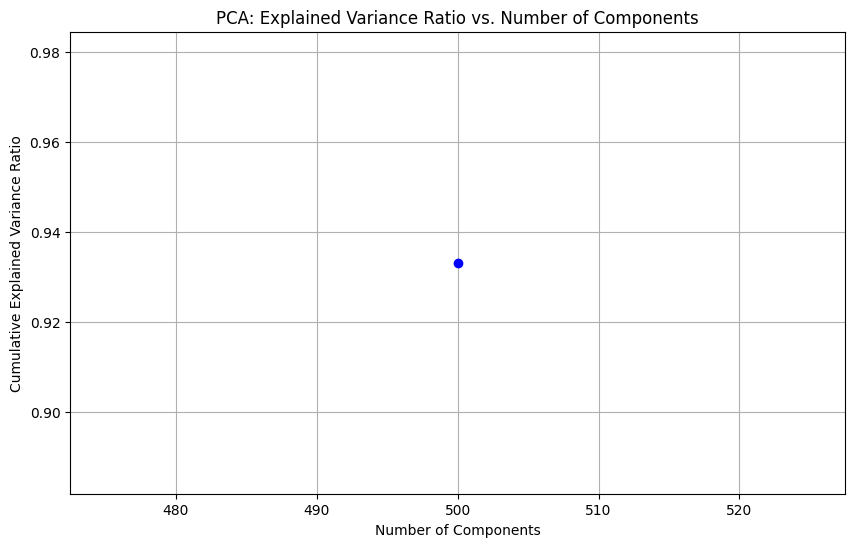

In [ ]:
# Flatten the 3D arrays into 2D arrays
flattened_x_values = combined_df['x_values'].apply(lambda x: np.concatenate(x))

# Perform PCA for various numbers of components
min_components = 500
max_components = 501 # Adjust the upper limit as needed
explained_variances = []

for n_components in range(min_components, max_components):
    pca = PCA(n_components=n_components)
    pca.fit(np.stack(flattened_x_values.values))  # Convert to 2D array before fitting PCA
    explained_variances.append(sum(pca.explained_variance_ratio_))

# Plot explained variance ratio
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(min_components, max_components), explained_variances, marker='o', linestyle='--', color='b')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('PCA: Explained Variance Ratio vs. Number of Components')
plt.grid(True)
plt.show()

In [ ]:
# Extract embeddings from the DataFrame and flatten them
embeddings = np.vstack(combined_df['x_values'].apply(lambda x: np.array(x)).values)

# Perform PCA for dimensionality reduction
n_components = 500  # You can adjust this based on your data
pca = PCA(n_components=n_components)
reduced_embeddings = pca.fit_transform(embeddings)

In [ ]:
# Define the range of cluster numbers to try
min_clusters = 2
max_clusters = 50

# Initialize lists to store results
wcss = []  # Within-cluster sum of squares
silhouette_scores = []

# Perform K-means clustering for different numbers of clusters
for num_clusters in range(min_clusters, max_clusters + 1):
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(reduced_embeddings)

    # Append the within-cluster sum of squares (WCSS) to the list
    wcss.append(kmeans.inertia_)

    # Calculate the Silhouette score and append it to the list
    silhouette_avg = silhouette_score(reduced_embeddings, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)

# Plot the WCSS to find the optimal number of clusters (elbow method)
plt.figure(figsize=(10, 5))
plt.plot(range(min_clusters, max_clusters + 1), wcss, marker='o', linestyle='-', color='b')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.xticks(range(min_clusters, max_clusters + 1))
plt.grid(True)
plt.show()

# Plot the Silhouette scores to find the optimal number of clusters
plt.figure(figsize=(10, 5))
plt.plot(range(min_clusters, max_clusters + 1), silhouette_scores, marker='o', linestyle='-', color='b')
plt.title('Silhouette Score for Optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(range(min_clusters, max_clusters + 1))
plt.grid(True)
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


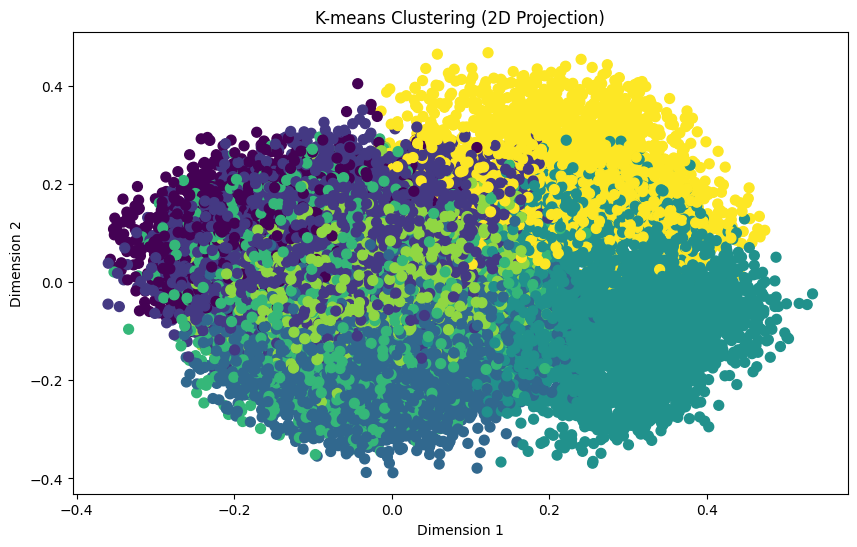

In [ ]:
# Number of clusters
num_clusters = 7

# Initialize K-means with the chosen number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)

# Fit K-means to your data (reduced_embeddings)
kmeans.fit(reduced_embeddings)

# Get the cluster labels for each data point
cluster_labels = kmeans.labels_

# Add the cluster labels to your DataFrame
combined_df['Cluster'] = cluster_labels

# Check the number of dimensions after PCA
num_pca_components = reduced_embeddings.shape[1]

if num_pca_components == 2:
    plt.figure(figsize=(10, 6))
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=cluster_labels, cmap='viridis', s=50)
    plt.title('K-means Clustering (2D Visualization)')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.show()
else:
    # You can choose to visualize a 2D projection or use other techniques like t-SNE
    # For example, for a 2D projection:
    pca_2d = PCA(n_components=2)
    reduced_embeddings_2d = pca_2d.fit_transform(embeddings)

    plt.figure(figsize=(10, 6))
    plt.scatter(reduced_embeddings_2d[:, 0], reduced_embeddings_2d[:, 1], c=cluster_labels, cmap='viridis', s=50)
    plt.title('K-means Clustering (2D Projection)')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.show()

## Map back to Original Words

In [ ]:
# Define the base path for the output text files
output_base_path = "/content/drive/MyDrive/output_cluster_"

# Loop through all unique clusters
for cluster_number in combined_df['Cluster'].unique():
    # Filter the DataFrame to get entities in the current cluster
    cluster_entities = combined_df[combined_df['Cluster'] == cluster_number]

    # Extract the Entity IDs of entities in the current cluster
    cluster_entity_ids = cluster_entities['Entity ID'].tolist()

    # Retrieve the original sentences for these entities from your loader
    original_sentences = []
    for entity_id in cluster_entity_ids:
        # Depending on the dataset prefix, use the appropriate loader
        if entity_id.startswith('A_'):
            entity_id = int(entity_id[2:])  # Remove the 'A_' prefix
            original_sentence = embeder.loader1[entity_id]
        elif entity_id.startswith('B_'):
            entity_id = int(entity_id[2:])  # Remove the 'B_' prefix
            original_sentence = embeder.loader2[entity_id]
        else:
            original_sentence = None  # Handle the case where the entity ID format is different

        if original_sentence:
            original_sentences.append(original_sentence)

    # Define the path for the current cluster's output text file
    output_text_file_path = output_base_path + str(cluster_number) + ".txt"

    # Save the original sentences to the text file for the current cluster
    with open(output_text_file_path, 'w', encoding='utf-8') as text_file:
        for sentence in original_sentences:
            text_file.write(sentence + '\n')